检测到路径回退，位置：1388
检测到路径回退，位置：1703


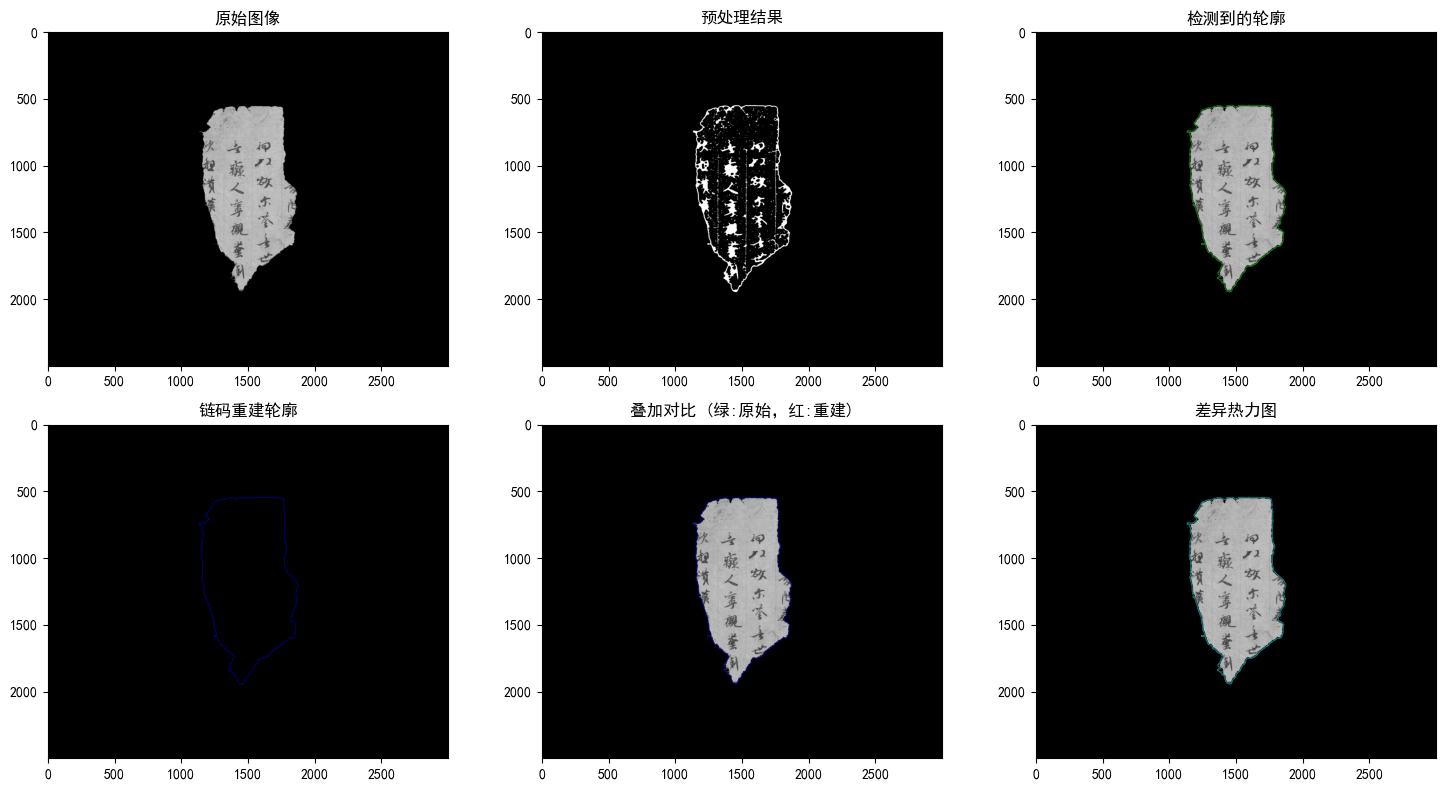

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 设置 matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def freeman_chain_code(contour):
    """改进的Freeman链码生成函数，包含闭合处理"""
    directions = [0, 1, 2, 3, 4, 5, 6, 7]
    dx = [1, 1, 0, -1, -1, -1, 0, 1]
    dy = [0, 1, 1, 1, 0, -1, -1, -1]
    chain_code = []
    
    # 强制闭合处理：连接首尾点
    for i in range(len(contour)):
        current = contour[i % len(contour)][0]
        next_p = contour[(i + 1) % len(contour)][0]
        delta = (next_p[0] - current[0], next_p[1] - current[1])
        
        # 精确方向匹配
        found = False
        for j, (ddx, ddy) in enumerate(zip(dx, dy)):
            if delta == (ddx, ddy):
                chain_code.append(j)
                found = True
                break
        if not found:
            raise ValueError(f"Invalid direction delta: {delta} at index {i}")
    
    return chain_code

# 图像读取（替换为你的实际路径）
image_path = r"C:\Users\28489\Desktop\paired\12\2.jpg"
original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 增强预处理流程
def preprocess(img):
    """改进的预处理管道"""
    # 降噪处理
    blurred = cv2.GaussianBlur(img, (7, 7), 1.5)
    
    # 自适应阈值
    thresh = cv2.adaptiveThreshold(blurred, 255, 
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY_INV, 21, 6)
    
    # 形态学操作
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    return closed

processed = preprocess(original)

# 精确轮廓检测
contours, _ = cv2.findContours(processed, 
                              cv2.RETR_EXTERNAL, 
                              cv2.CHAIN_APPROX_NONE)

# 智能轮廓筛选
def is_valid_contour(cnt):
    """轮廓有效性验证"""
    area = cv2.contourArea(cnt)
    if area < 500:  # 最小面积阈值
        return False
    
    # 边界检查
    x, y, w, h = cv2.boundingRect(cnt)
    if (x == 0 or y == 0 or 
        x + w >= original.shape[1] - 1 or 
        y + h >= original.shape[0] - 1):
        return False  # 排除边界接触的轮廓
    
    # 形状检查
    solidity = area / (w * h)
    return 0.3 < solidity < 0.9  # 排除过于稀疏或紧凑的形状

valid_contours = [cnt for cnt in contours if is_valid_contour(cnt)]

if not valid_contours:
    raise ValueError("未找到有效轮廓，请调整预处理参数")

# 选择最佳轮廓（可改为多轮廓处理）
best_contour = max(valid_contours, key=lambda c: cv2.contourArea(c))

# 生成链码
chain_code = freeman_chain_code(best_contour)

# 链码验证重建
def reconstruct_from_code(chain, start_point, img_shape):
    """带路径验证的重建函数"""
    dx = [1, 1, 0, -1, -1, -1, 0, 1]
    dy = [0, 1, 1, 1, 0, -1, -1, -1]
    
    path = [start_point]
    current = np.array(start_point)
    
    for code in chain:
        step = np.array([dx[code], dy[code]])
        next_point = current + step
        
        # 严格边界约束
        next_point = np.clip(next_point, 
                            [0, 0], 
                            [img_shape[1]-1, img_shape[0]-1])
        
        # 路径冲突检查
        if len(path) > 1 and np.array_equal(next_point, path[-2]):
            print(f"检测到路径回退，位置：{len(path)}")
        
        path.append(next_point.copy())
        current = next_point
    
    return np.array(path, dtype=np.int32)

# 执行重建
start_point = tuple(best_contour[0][0])
reconstructed = reconstruct_from_code(chain_code, 
                                     start_point,
                                     original.shape)

# 可视化对比
plt.figure(figsize=(15, 8))

# 原始处理结果
plt.subplot(231)
plt.imshow(original, cmap='gray')
plt.title('原始图像')

plt.subplot(232)
plt.imshow(processed, cmap='gray')
plt.title('预处理结果')

# 轮廓对比
contour_img = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, [best_contour], -1, (0,255,0), 2)

plt.subplot(233)
plt.imshow(contour_img)
plt.title('检测到的轮廓')

# 重建结果
recon_img = np.zeros_like(contour_img)
cv2.polylines(recon_img, [reconstructed], False, (0,0,255), 2)

plt.subplot(234)
plt.imshow(recon_img)
plt.title('链码重建轮廓')

# 叠加对比
overlay = contour_img.copy()
cv2.polylines(overlay, [reconstructed], False, (0,0,255), 2)

plt.subplot(235)
plt.imshow(overlay)
plt.title('叠加对比 (绿:原始，红:重建)')

# 误差分析
diff = cv2.absdiff(contour_img, recon_img)
plt.subplot(236)
plt.imshow(diff, cmap='jet')
plt.title('差异热力图')

plt.tight_layout()
plt.show()